In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import datetime
import pickle
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import R2Score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dfr = pd.read_pickle('/home/rouse_ai/nha/KLTN/ratings.pickle')
dfu = pd.read_pickle('/home/rouse_ai/nha/KLTN/user_info.pickle')
dfm = pd.read_pickle('/home/rouse_ai/nha/KLTN/movie_info.pickle')

In [4]:
genres = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western",]
num_genres = len(genres)

In [5]:
df = pd.concat([pd.merge(dfr[['userIDX']], dfu, on='userIDX', how='left'), 
           pd.merge(dfr[['movieIDX']], dfm, on='movieIDX', how='left'),
           dfr[['rating']]], axis=1)
del dfr, dfu, dfm

In [6]:
size_onehot_each_column = df.iloc[:, :-2].max().values + 1

In [7]:
cumsum_size_onehot = np.cumsum(size_onehot_each_column)
df.iloc[:, 1:-2] = df.iloc[:, 1:-2] + cumsum_size_onehot[:-1]

In [8]:
size_vector_onehot_total = cumsum_size_onehot[-1] + num_genres

In [9]:
size_vector_onehot_total

9993

In [10]:
df['genres'] = df['genres'].map(lambda x: np.asarray(x))
df['genres'] = df['genres'] + cumsum_size_onehot[-1]

# padding thêm để load được dưới dạng batch. Mở rộng ma trận embedding thêm 1 hàng và không dùng đến hàng này. Trong vector onehot của genre,  những giá trị khác 1 
# trong genres sẽ được fill = size vector onehot, có nghĩa là khi đc embedding, nó sẽ tương ứng với hàng cuối cùng (đc mở rộng ở trên) nên kh xài.
def padding_genres(x, len_=num_genres):
    pad_arr = np.full(num_genres-len(x), fill_value=size_vector_onehot_total, dtype=int)
    return np.concatenate((x, pad_arr), axis=0).astype(int)

df['genres'] = df['genres'].map(lambda x: padding_genres(x))

In [11]:
df_genres = pd.DataFrame(np.asarray(list(df['genres'].values)), columns=[f'genre_{i}' for i in range(1, num_genres+1)])

In [12]:
df = pd.concat([df.iloc[:, :-2], df_genres, df['rating']], axis=1)

In [13]:
df['rating'] = df['rating'] - 3

In [14]:
df

,userIDX,gender,age,occupation,movieIDX,year,genre_1,genre_2,genre_3,genre_4,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,rating
0,0,6040,6042,6059,7246,9965,9982,9993,9993,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,2
1,0,6040,6042,6059,6725,9972,9977,9978,9986,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,0
2,0,6040,6042,6059,6972,9963,9986,9988,9993,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,0
3,0,6040,6042,6059,9409,9974,9982,9993,9993,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,1
4,0,6040,6042,6059,8356,9973,9977,9978,9979,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6039,6041,6044,6055,7145,9969,9979,9993,9993,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,-2
1000205,6039,6041,6044,6055,7148,9970,9982,9988,9991,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,2
1000206,6039,6041,6044,6055,6628,9972,9979,9982,9993,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,2
1000207,6039,6041,6044,6055,7150,9967,9982,9993,9993,9993,...,9993,9993,9993,9993,9993,9993,9993,9993,9993,1


In [15]:
data_train, data_test = train_test_split(df.values, test_size=0.12, random_state=69)
del df

In [16]:
class MovieDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        one_indices_ = self.data[idx, :-1]
        label_ = self.data[idx, -1]

        one_indices_ = torch.from_numpy(one_indices_).type(torch.int32)
        label_ = torch.tensor(label_, dtype=torch.float32)
        
        return one_indices_, label_

In [17]:
# ctr_dataset = MovieDataset(data=data_train)
# dataloader = DataLoader(ctr_dataset, batch_size=8, shuffle=True, num_workers=0)
# for sample_batched in dataloader:
#     break

In [18]:
class FM(nn.Module):
    def __init__(self, size_vector_onehot, num_og_feature, num_factors):
        """
        Deep Factorization Machine model

        Args:
            size_vector_onehot (int): size vector onehot
            num_og_feature (int): num original features
            num_factors (int): size of latent vector
        """

        super(FM, self).__init__()
        self.size_vector_onehot = size_vector_onehot
        self.num_factors = num_factors
        self.embedding = nn.Embedding(size_vector_onehot + 1 , num_factors, padding_idx=size_vector_onehot)
        self.linear_layer = nn.Embedding(size_vector_onehot + 1, 1, padding_idx=size_vector_onehot)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)
        # self.scaled_down = nn.Parameter(torch.tensor(0.025), requires_grad=False)

    def forward(self, x):
        """
        Only works for data in batch format
        Args:
            x (array like): (batchsize, one indices)

        Returns:
              feature (torch.Tensor) : (batch_size, num_factors)
        """

        embedded_xs = self.embedding(x)

        # ---------------FM--------------------
        square_of_sum = embedded_xs.sum(1).pow(2).sum(1)
        sum_of_square = embedded_xs.pow(2).sum(1).sum(1)

        degree2_part =  0.5 * (square_of_sum - sum_of_square)
        degree2_part = torch.unsqueeze(degree2_part, -1)

        linear_part = self.linear_layer(x).sum(1) + self.bias

        out = linear_part + degree2_part

        out = out[:, 0]
        out = torch.clamp(out, min=-2.1, max=2.1)

        return out


In [19]:
batch_size = 768
dataset_train = MovieDataset(data=data_train)
dataset_test = MovieDataset(data=data_test)
loaders = {'train': DataLoader(dataset_train, batch_size, num_workers=10, shuffle=True),
          'val': DataLoader(dataset_test, batch_size, num_workers=10, shuffle=False)}

In [20]:
num_factors=4
model = FM(size_vector_onehot=size_vector_onehot_total, num_og_feature=data_train.shape[1]-1, num_factors=num_factors)
model = model.to(DEVICE)

In [21]:
def lr_base_on_epoch(epoch:int):
    if epoch <=10:
        gamma = 0.011
    elif epoch <=15:
        gamma = 0.005
    elif epoch <=20:
        gamma = 0.0025
    elif epoch <=30:
        gamma = 1e-3
    elif epoch <=40:
        gamma = 7e-4
    elif epoch <=55:
        gamma = 5e-4
    elif epoch <=70:
        gamma = 1e-4
    else:
        gamma = 2e-5
    return gamma

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1)
lambda_function = lambda epoch: lr_base_on_epoch(epoch=epoch)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_function)
metric = R2Score().to(DEVICE)

In [ ]:
### FINE TUNEEEEEEEEEEEEEEEEE
def lr_base_on_epoch(epoch:int):
    return 4e-4

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1)
lambda_function = lambda epoch: lr_base_on_epoch(epoch=epoch)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_function)
metric = R2Score().to(DEVICE)

In [22]:
best_val_loss = 9999

In [1]:
logs = []
first_epoch = True
for epoch in range(81):
    current_log = {'epoch': epoch, 'loss_train': 0., 'loss_val': 0., 'val_R2_score':0., 'lr': optimizer.param_groups[0]["lr"]}
    start_time = time.time()
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for sample_batched in loaders[phase]:
            optimizer.zero_grad()

            one_indices, label = sample_batched
            one_indices = one_indices.to(DEVICE)
            label = label.to(DEVICE)
            pred = model(one_indices)#.to(DEVICE)
            loss = criterion(pred, label)

            current_log[f"loss_{phase}"] += loss.item() * batch_size
            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            if phase == 'val':
                with torch.no_grad():
                    metric.update(pred, label)
        current_log[f"loss_{phase}"] /= len(loaders[phase].dataset)
    current_log['val_R2_score'] = metric.compute().item()
    scheduler.step()

    if current_log['loss_val'] < best_val_loss:
        torch.save(model.state_dict(), 'FM_regr.pth')
        best_val_loss = current_log['loss_val']
    else:
        if first_epoch==False:
            if epoch < 15:
                if (current_log['loss_val'] - best_val_loss) > 1:
                    model.load_state_dict(torch.load('FM_regr.pth'))
            elif epoch < 25:
                if (current_log['loss_val'] - best_val_loss) > 0.05:
                    model.load_state_dict(torch.load('FM_regr.pth'))
            else:
                if (current_log['loss_val'] - best_val_loss) > 0.011:
                    model.load_state_dict(torch.load('FM_regr.pth'))
    

    print(f'Epoch {epoch:3d}   train loss: {current_log["loss_train"]:.4f}  -  val loss: {current_log["loss_val"]:.4f}  -  val R2_score: {current_log["val_R2_score"]:.4f}  -  lr: {optimizer.param_groups[0]["lr"]}  -  time: {(time.time()-start_time):6f}')
    logs.append(current_log)
    first_epoch = False
pickle.dump(logs, open(f'logs_FM{num_factors}_Adam_regr_{str(datetime.datetime.now())}.pkl', 'wb'))

In [ ]:
model.load_state_dict(torch.load('FM_regr.pth'))

In [44]:
list_pred = []
with torch.no_grad():
    for sample_batched in loaders['val']:
        one_indices, label = sample_batched
        one_indices = one_indices.to(DEVICE)
        pred = model(one_indices).detach().cpu().numpy().tolist()
        list_pred.extend(pred)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
loss_trains = np.asarray([logs[i]['loss_train'] for i in range(len(logs))])
loss_vals = np.asarray([logs[i]['loss_val'] for i in range(len(logs))])
val_accs = np.asarray([logs[i]['val_R2_score'] for i in range(len(logs))])
lrs = np.asarray([logs[i]['lr'] for i in range(len(logs))])

In [49]:
min(loss_vals)

0.7742017734180462

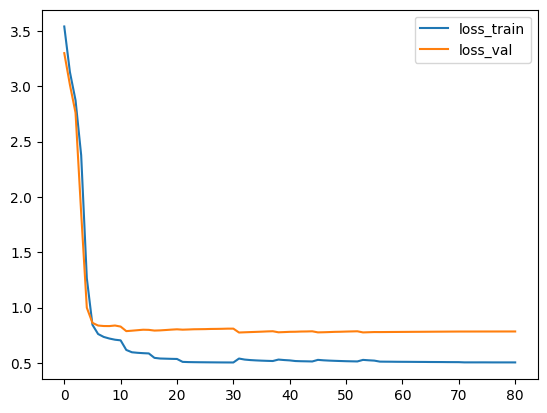

In [50]:
plt.plot(loss_trains, label='loss_train')
plt.plot(loss_vals, label='loss_val')

plt.legend()

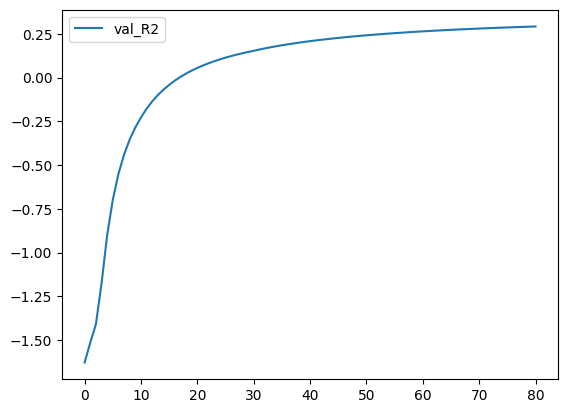

In [52]:
plt.plot(val_accs, label='val_R2')
plt.legend()

In [53]:
max(val_accs)

0.29214298725128174

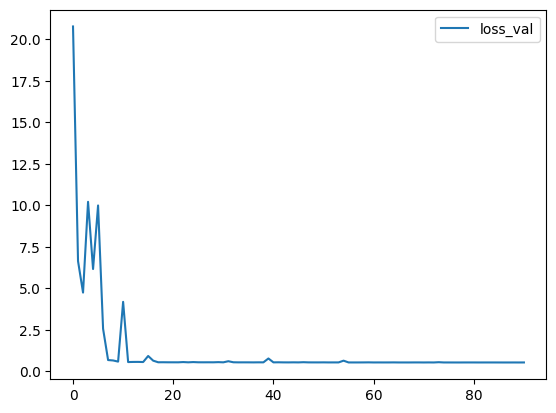

In [ ]:
plt.plot([logs[i]['loss_val'] for i in range(len(logs))], label='loss_val')
plt.legend()

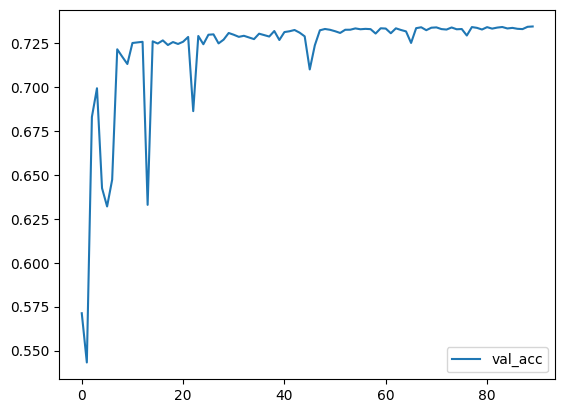

In [ ]:
plt.plot([logs[i]['val_acc'] for i in range(len(logs))], label='val_acc')
# plt.plot([logs[i]['lr'] for i in range(len(logs))], label='lr')
plt.legend()

In [ ]:
# Intel(R) Core(TM) i9-10900X CPU @ 3.70GHz
# NVIDIA GeForce RTX 3090